In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
#just in case, install the kaggle environment
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

In [ ]:
#!pip uninstall scipy numpy -y


In [2]:
!pip install numpy==1.26.4

In [3]:
#install duck duck go search
!pip install ddgs
from ddgs import DDGS  
from fastcore.all import *
#define function which returns duck duck go search
def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.8 MB/s eta 0:00:0000:0100:01


In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('cat photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/1784289/pexels-photo-1784289.jpeg?cs=srgb&dl=adorable-animal-baby-1784289.jpg&fm=jpg'

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

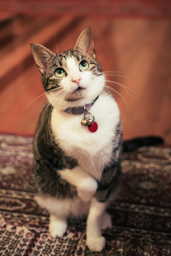

In [6]:
from fastdownload import download_url
dest = 'cat.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

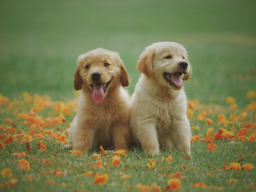

In [9]:
#same for dogs
download_url(search_images('dogs photos', max_images=1)[0], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

In [10]:
# let's grab a few examples of each of "cat" and "dog" photos, and save each group of photos to a different folder
searches = 'cat','dog'
path = Path('cat_or_dog')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [11]:
#Some photos might not download correctly which could cause our model training to fail, so we'll remove them
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

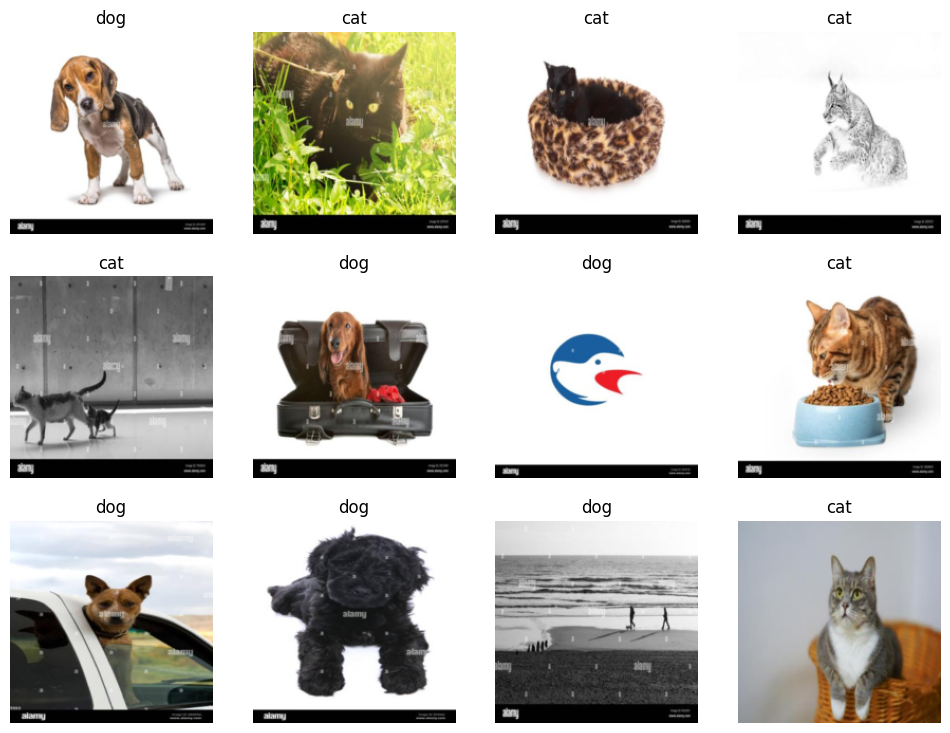

In [12]:
#to train a model, we'll need DataLoaders, which is an object that contains a training and a validation sets
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.051517,0.620215,0.184211,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.425754,0.290214,0.157895,00:00
1,0.293281,0.247259,0.131579,00:00
2,0.225725,0.281760,0.131579,00:00


In [ ]:
'''"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset 
(called the pretrained model), 
and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, 
and widely-used computer vision dataset with images covering 1000 categories)'''

In [ ]:
#let's see how model sees cats
is_cat,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")